## FACIAL AGE RECOGNITION
---
*Mónica De Santos*

*Ana Elósegui*

El objetivo de este trabajo es profundizar sobre las diferentes técnicas de visión artificial utilizadas para el análisis de imagen y presentar el problema de esta categoría escogido para llevar a la práctica lo aprendido.

En concreto se va a trabajar un problema de visión computacional que predice la edad de una persona a partir de una imagen dada, para ello se parte de un dataset de 9745 imágenes de personas cuyas edades están entre 1 y 90 años. En este caso se ha decidido tratar la edad como una variable continua, por lo que se trata de un problema de regresión lineal.

En primer lugar se realizarán las transformaciones necesarias para poder trabajar con los datos en el formato que se quiere. Tras realizar un análisis exploratorio, se realizará el preprocesamiento necesario para poder abordar el problema. El siguiente paso será entrenar diferentes modelos que soporten la visión computacional y analizar los resultados obtenidos al variar los parámetros de estos. Por último, se compararán los resultados obtenidos para poder elegir aquel que se considera el mejor y poder testearlo sobre un conjuntos de imágenes destinadas a ello. 

### Carga de librerías

In [1]:
import numpy as np
import pandas as pd
import cv2
import os
import random
from numpy.random import seed

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Flatten, Dense, BatchNormalization
from keras import regularizers, Model
from tensorflow.keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder # one-hot encoding for age
from keras.utils.np_utils import to_categorical
from keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications import VGG16
from keras.callbacks import Callback, ReduceLROnPlateau, EarlyStopping
from timeit import default_timer as timer
from sklearn.model_selection import train_test_split

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

### Directorios

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
#ANA

%cd /content/drive/MyDrive/ICAI/Datos no estructurados/Facial Age Recognition/
image_path = os.getcwd() + '/face_age/'

/content/drive/MyDrive/ICAI/Datos no estructurados/Facial Age Recognition


In [4]:
##MONI

# %cd /content/drive/MyDrive/Facial Age Recognition
# image_path = os.getcwd() + '/face_age/'

### Carga del dataset

Como se ha mencionado arriba, se va a trabajar con un dataset de muchas fotos que corresponden a edades comprendidas entre el año y los 90 años que están guardadas en diferentes carpetas. Por lo tanto para poder tratar con estas fotos y asociarlas a la edad se crean dos listas, X e Y, donde se van a almacenar respectivamente los pixeles de las imagenes y la edad a la que corresponden, la cual coincide con el nombre de la carpeta que contiene la foto. 

En cuanto al tratamiento de las imágenes, se convierten a 'RGB' y se fija el tamaño deseado, que en este caso es de 100x100. 

In [5]:
X = []
Y = []
width = 100
height = 100

for folder_name,_,filenames in os.walk(image_path):
    if folder_name !="face_age" and folder_name != 'Data':
        for file in filenames:
            file_path = folder_name +"/"+ file
            image = Image.open(file_path)
            image = image.convert('RGB')
            image = image.resize((width, height))
            X.append(np.array(image))
            Y.append(int(folder_name[-3:]))
    else:
        pass

### Análisis exploratorio

Una vez se tienen las imágenes y las etiquetas de la edad de una forma en la que se puedan tratar, se quiere realizar un análisis para conocer estos datos mejor. 

In [6]:
list_age = []
list_count = []

for i in range(1, 90):
  list_age.append(i)
  list_count.append(Y.count(i))


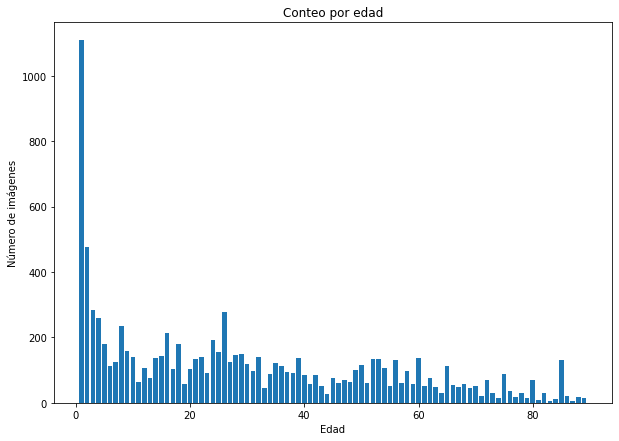

In [7]:
plt.figure(figsize=(10, 7))
plt.bar(list_age, list_count)
plt.title("Conteo por edad")
plt.xlabel("Edad")
plt.ylabel("Número de imágenes")
plt.show()

En el gráfico anterior se puede observar como en el dataset original existen más imágenes para las edades comprendidas entre 1 y 3 años. A partir de ahí la cantidad de imágenes correspondientes a cada edad va disminuyendo. Este problema de desbalanceo se abordará más adelante mediante Data Augmentation.

Además también se muestran varias fotos del dataset para poder visualizarlas antes de trabajar en los modelos.

Text(0.5, 1.0, 'Edad: 3')

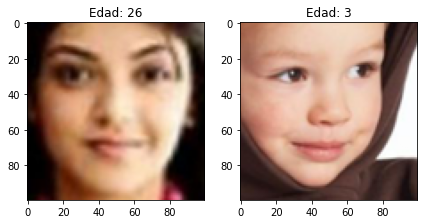

In [33]:
sample_1 = random.randint(0, len(X))
sample_2 = random.randint(0, len(X))

plt.figure(figsize=(7, 7))
plt.subplot(1, 2, 1)
plt.imshow(X[sample_1])
plt.title("Edad: " + str(Y[sample_1]))
plt.subplot(1, 2, 2)
plt.imshow(X[sample_2])
plt.title("Edad: " + str(Y[sample_2]))

### Preprocesamiento

In [9]:
X = np.array(X)
X = X.astype('float32')
X /= 255.0

Y = np.array(Y)

In [10]:
# os.mkdir("Data")

try:
    os.remove("Data")
#     os.remove("Data/X.npy")
#     os.remove("Data/Y.npy")
#     os.remove("Data/X_train.npy")
#     os.remove("Data/Y_train.npy")
#     os.remove("Data/X_test.npy")
#     os.remove("Data/Y_test.npy")
#     os.remove("Data/X_val.npy")
#     os.remove("Data/Y_val.npy")
except OSError:
    pass

A continuación se divide el dataset en el conjunto de entrenamiento (70%), validación (15%) y test (15%).

In [11]:
test_size = 0.3
seed = 42
X_train, X_test, Y_train, Y_test = train_test_split(X, 
                                                    Y,
                                                    test_size=test_size, 
                                                    random_state=seed,
                                                    shuffle=True,
                                                    stratify=Y)

X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, test_size=0.5)

Se guardan estos conjuntos divididos en archivos de numpy array para evitar tener que cargar los datos y preprocesarlos cada vez que se quieran probar modelos. 

In [12]:
# save to files
np.save('Data/X_train.npy', X_train)
np.save('Data/Y_train.npy', Y_train)
np.save('Data/X_val.npy', X_val)
np.save('Data/Y_val.npy', Y_val)
np.save('Data/X_test.npy', X_test)
np.save('Data/Y_test.npy', Y_test)

Se realiza Data Augmentation, tanto como para train como para test. Se van a generar imágenes rotadas tanto horizontal y verticalmente. El rango de rotación en grados es de 20, la manera en que se colorean los píxeles de alrededor de los bordes es de acuerdo a los colores de los píxeles de los propios bordes.

In [13]:
train_datagen = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.1,
    fill_mode="nearest")

test_datagen = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.1,
    fill_mode="nearest")

### Callbacks e hiperparámetros

Además, para mejorar el rendimiento de la ejecución de los modelos se fijan los siguientes callbacks, que serán aplicados más adelante. 


*   early_stopping: Si en 8 épocas el la métrica de la función de pérdida de validación no ha mejorado en un 1% forzar la parada del modelo. 
*   reduce_learning_rate: Si en 3 épocas la métrica de la función de pérdida de validación no ha mejorado en un 10%, forzar la reducción de la tasa de aprendizaje. 





In [14]:
class TimingCallback(Callback):
    def __init__(self, logs={}):
        self.logs=[]
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)

early_stopping = EarlyStopping(
                                patience = 8, 
                                min_delta = 0.01,   
                                verbose = 1, 
                                mode = 'min',
                                monitor='val_loss')

reduce_learning_rate = ReduceLROnPlateau(
                                    monitor="val_loss",
                                    patience = 3,             
                                    episilon= 0.1,
                                    factor=0.1,  
                                    cooldown = 3, 
                                    verbose=1)

El siguiente paso es determinar los hiperparámetros que serán aplicados en el modelo. En este caso se ha elegido comenzar con una tasa de aprendizaja de 0.01 y el batch_size se ha fijado a 128. 

In [15]:
lr = 0.01
epochs = 100 
batch_size = 128
input_shape = [width,height]
num_of_ages = 90

results = {}

### Modelos 

Tras haber hecho un pequeño análisis de las imágenes con las que se va trabajar y del problema a abordar, así como haber realizado el preprocesamiento de los datos, se han probado diferentes modelos para el conjunto de entrenamiento. 

En este notebook se presentan aquellos diferentes tipos de modelos que han resultado más interesantes y que merece la pena comentar, ya que no es posible incluir todos los modelos con los distintos hiperparámetros fijados y las capas que componen cada uno de ellos. 

A continuación se explican en general la función de las diferentes capas añadidas en estos modelos:


*   Capa de convolución: Esta capa aplica filtros de manera convolucional a las imágenes. En este caso se la función de activación es de tipo relu, con filtro de 3x3 píxeles. 
*   Capa normalización
*   Capa polling: Reduce la información de la capa anterior con píxeles 2x2.
*   Capa flatten: Convierte la matriz de features a un vector. 
*   Capa dropout: En ella se eliminan de manera aleatoria la mitad de las unidades de input, para evitar el sobreentrenamiento.
*   Capa dense: Determina la salida del modelo, en este caso la activación es lineal, lo que permite que el output sea una variable continua.

Además, en todos los modelos presentados se ha añadido el optimizador Adam, el cual mejora la eficiencia de los modelos. 



#### Modelo 1. MobilNET

In [16]:
base_mobilenet_model = MobileNet(input_shape =  (input_shape[0],input_shape[1], 3), 
                                 include_top = False, 
                                 weights = None)
mobilenet_model = Sequential()
mobilenet_model.add(BatchNormalization(input_shape = (input_shape[0],input_shape[1], 3)))
mobilenet_model.add(base_mobilenet_model)
mobilenet_model.add(BatchNormalization())
mobilenet_model.add(GlobalAveragePooling2D())
mobilenet_model.add(Dropout(0.5))
mobilenet_model.add(Dense(1,activation='linear')) 



mobilenet_model.compile(optimizer = 'adam', loss = 'mean_absolute_error',
                           metrics = ["mean_absolute_error"])

# Fit model on training data
mobilenet_model_history = mobilenet_model.fit(
            train_datagen.flow(X_train,Y_train,
                         batch_size = batch_size), 
            validation_data = (X_val,Y_val),
            epochs = epochs,
            callbacks = [
                         reduce_learning_rate,
                         early_stopping
                        ],
            verbose=True)

Epoch 1/100
54/54 [==============================] - 34s 493ms/step - loss: 28.0492 - mean_absolute_error: 28.0492 - val_loss: 26.8551 - val_mean_absolute_error: 26.8551 - lr: 0.0010
Epoch 2/100
54/54 [==============================] - 25s 461ms/step - loss: 24.1262 - mean_absolute_error: 24.1262 - val_loss: 23.1547 - val_mean_absolute_error: 23.1547 - lr: 0.0010
Epoch 3/100
54/54 [==============================] - 23s 431ms/step - loss: 18.2679 - mean_absolute_error: 18.2679 - val_loss: 20.4735 - val_mean_absolute_error: 20.4735 - lr: 0.0010
Epoch 4/100
54/54 [==============================] - 23s 427ms/step - loss: 15.3571 - mean_absolute_error: 15.3571 - val_loss: 20.1388 - val_mean_absolute_error: 20.1388 - lr: 0.0010
Epoch 5/100
54/54 [==============================] - 23s 424ms/step - loss: 13.3752 - mean_absolute_error: 13.3752 - val_loss: 20.1763 - val_mean_absolute_error: 20.1763 - lr: 0.0010
Epoch 6/100
54/54 [==============================] - 23s 432ms/step - loss: 12.3043 -

In [17]:
mobilenet_train_loss = mobilenet_model_history.history["loss"]
mobilenet_val_loss = mobilenet_model_history.history["val_loss"]
mobilenet_train_acc = mobilenet_model_history.history["mean_absolute_error"]
mobilenet_val_acc = mobilenet_model_history.history["val_mean_absolute_error"]


results["mobilenet_adam"] = {'train-loss': mobilenet_train_loss,
                             'val-loss': mobilenet_val_loss,
                             'train-mae': mobilenet_train_acc,
                             'val-mae': mobilenet_val_acc}

Predicción

Text(0.5, 1.0, 'Edad real: 14 \n Edad predicha: 33.598')

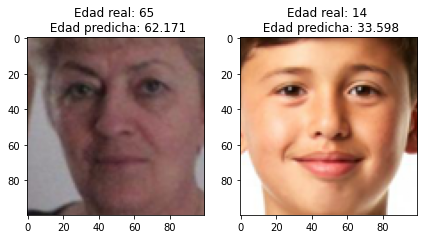

In [38]:
sample_pred_1 = random.randint(0, len(X_val))
sample_pred_2 = random.randint(0, len(X_val))

real_age_1 = str(Y_val[sample_pred_1])
prediction_image_1 = np.expand_dims(X_val[sample_pred_1], axis=0)
predicted_age_1 = float(mobilenet_model.predict(prediction_image_1)[0])

real_age_2 = str(Y_val[sample_pred_2])
prediction_image_2 = np.expand_dims(X_val[sample_pred_2], axis=0)
predicted_age_2 = float(mobilenet_model.predict(prediction_image_2)[0])

plt.figure(figsize=(7, 7))
plt.subplot(1, 2, 1)
plt.imshow(X_val[sample_pred_1])
plt.title("Edad real: {} \n Edad predicha: {:.3f}".format(real_age_1, predicted_age_1))
plt.subplot(1, 2, 2)
plt.imshow(X_val[sample_pred_2])
plt.title("Edad real: {} \n Edad predicha: {:.3f}".format(real_age_2, predicted_age_2))

#### Modelo 2. VGG 16

In [19]:
conv_base = VGG16(weights='imagenet',                
                  include_top=False,              
                  input_shape=(input_shape[0],input_shape[1], 3))

for layer in conv_base.layers: 
    layer.trainable = False

vgg_adam = Sequential() 
vgg_adam.add(conv_base) 
vgg_adam.add(MaxPooling2D())
vgg_adam.add(Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.00001)))
vgg_adam.add(Dropout(0.5))
vgg_adam.add(Flatten())
vgg_adam.add(Dense(1,activation="linear"))

vgg_adam.compile(optimizer = "adam",loss="mean_absolute_error", metrics=["mean_absolute_error"])

vgg_adam_history = vgg_adam.fit(
            train_datagen.flow(X_train,Y_train,
                         batch_size = batch_size), # use augmented images
            validation_data = (X_val,Y_val),
            steps_per_epoch=X_train.shape[0] // batch_size,
            epochs = epochs,
            callbacks = [
                         reduce_learning_rate,
                         early_stopping
                        ],
            verbose=True)

Epoch 1/100
53/53 [==============================] - 33s 539ms/step - loss: 18.4298 - mean_absolute_error: 18.4231 - val_loss: 14.2563 - val_mean_absolute_error: 14.2495 - lr: 0.0010
Epoch 2/100
53/53 [==============================] - 25s 475ms/step - loss: 14.3257 - mean_absolute_error: 14.3187 - val_loss: 12.6739 - val_mean_absolute_error: 12.6667 - lr: 0.0010
Epoch 3/100
53/53 [==============================] - 25s 476ms/step - loss: 13.4650 - mean_absolute_error: 13.4576 - val_loss: 11.7315 - val_mean_absolute_error: 11.7240 - lr: 0.0010
Epoch 4/100
53/53 [==============================] - 25s 475ms/step - loss: 12.8343 - mean_absolute_error: 12.8266 - val_loss: 11.5495 - val_mean_absolute_error: 11.5416 - lr: 0.0010
Epoch 5/100
53/53 [==============================] - 25s 478ms/step - loss: 12.6861 - mean_absolute_error: 12.6781 - val_loss: 11.1286 - val_mean_absolute_error: 11.1205 - lr: 0.0010
Epoch 6/100
53/53 [==============================] - 25s 475ms/step - loss: 12.5910 -

In [20]:
vgg_train_loss = vgg_adam_history.history["loss"]
vgg_val_loss = vgg_adam_history.history["val_loss"]
vgg_train_acc = vgg_adam_history.history["mean_absolute_error"]
vgg_val_acc = vgg_adam_history.history["val_mean_absolute_error"]


results["vgg_adam"] = {'train-loss': vgg_train_loss,
                             'val-loss': vgg_val_loss,
                             'train-mae': vgg_train_acc,
                             'val-mae': vgg_val_acc}

Predicción

Text(0.5, 1.0, 'Edad real: 14 \n Edad predicha: 23.634')

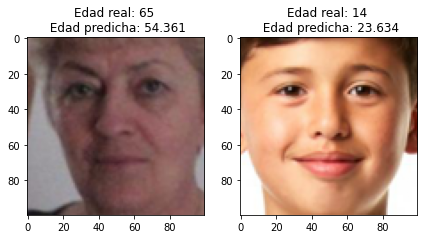

In [39]:
real_age_1 = str(Y_val[sample_pred_1])
prediction_image_1 = np.expand_dims(X_val[sample_pred_1], axis=0)
predicted_age_1 = float(vgg_adam.predict(prediction_image_1)[0])

real_age_2 = str(Y_val[sample_pred_2])
prediction_image_2 = np.expand_dims(X_val[sample_pred_2], axis=0)
predicted_age_2 = float(vgg_adam.predict(prediction_image_2)[0])

plt.figure(figsize=(7, 7))
plt.subplot(1, 2, 1)
plt.imshow(X_val[sample_pred_1])
plt.title("Edad real: {} \n Edad predicha: {:.3f}".format(real_age_1, predicted_age_1))
plt.subplot(1, 2, 2)
plt.imshow(X_val[sample_pred_2])
plt.title("Edad real: {} \n Edad predicha: {:.3f}".format(real_age_2, predicted_age_2))

#### Modelo 3. CNN

In [22]:
inputs = keras.Input(shape=(100, 100, 3))
chanDim = -1
# define the model input
# flatten the volume, then FC => RELU => BN => DROPOUT
x = Conv2D(16, (3, 3), padding="same", activation = "relu")(inputs)
x = keras.layers.BatchNormalization(axis=chanDim)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
    
x = Conv2D(32, (3, 3), padding="same", activation = "relu")(x)
x = keras.layers.BatchNormalization(axis=chanDim)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(64, (3, 3), padding="same", activation = "relu")(x)
x = keras.layers.BatchNormalization(axis=chanDim)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(128, (3, 3), padding="same", activation = "relu")(x)
x = keras.layers.BatchNormalization(axis=chanDim)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(256, (3, 3), padding="same", activation = "relu")(x)
x = keras.layers.BatchNormalization(axis=chanDim)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
    
x = Flatten()(x)
x = Dense(256, activation = "relu")(x)
# x = Dense(16, activation = "relu")(x)

# x = keras.Activation("relu")(x)
x = keras.layers.BatchNormalization(axis=chanDim)(x)
x = Dropout(0.5)(x)
x = Dense(1, activation = "linear")(x)

cnn_adam_model = keras.Model(inputs=inputs, outputs=x)

cnn_adam_model.compile(optimizer="adam",loss="mean_absolute_error",metrics=['mean_absolute_error'])

cnn_adam_model_history = cnn_adam_model.fit(
            train_datagen.flow(X_train,Y_train,
                         batch_size = batch_size), # use augmented images
            validation_data = (X_val,Y_val),
            steps_per_epoch=X_train.shape[0] // batch_size,
            epochs = epochs,
            callbacks = [
                         reduce_learning_rate,
                         early_stopping
                        ], verbose=True)

Epoch 1/100
53/53 [==============================] - 21s 354ms/step - loss: 28.7207 - mean_absolute_error: 28.7207 - val_loss: 29.1077 - val_mean_absolute_error: 29.1077 - lr: 0.0010
Epoch 2/100
53/53 [==============================] - 18s 346ms/step - loss: 27.2266 - mean_absolute_error: 27.2266 - val_loss: 24.9775 - val_mean_absolute_error: 24.9775 - lr: 0.0010
Epoch 3/100
53/53 [==============================] - 19s 351ms/step - loss: 24.5467 - mean_absolute_error: 24.5467 - val_loss: 25.7901 - val_mean_absolute_error: 25.7901 - lr: 0.0010
Epoch 4/100
53/53 [==============================] - 19s 349ms/step - loss: 20.3405 - mean_absolute_error: 20.3405 - val_loss: 26.3495 - val_mean_absolute_error: 26.3495 - lr: 0.0010
Epoch 5/100
53/53 [==============================] - ETA: 0s - loss: 15.9775 - mean_absolute_error: 15.9775
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
53/53 [==============================] - 18s 348ms/step - loss: 15.9775 - mean_abso

In [23]:
cnn_adam_train_loss = cnn_adam_model_history.history["loss"]
cnn_adam_val_loss = cnn_adam_model_history.history["val_loss"]
cnn_adam_train_acc = cnn_adam_model_history.history["mean_absolute_error"]
cnn_adam_val_acc = cnn_adam_model_history.history["val_mean_absolute_error"]


results["cnn_adam"] = {'train-loss': cnn_adam_train_loss,
                             'val-loss': cnn_adam_val_loss,
                             'train-mae': cnn_adam_train_acc,
                             'val-mae': cnn_adam_val_acc}

Predicción

Text(0.5, 1.0, 'Edad real: 14 \n Edad predicha: 8.727')

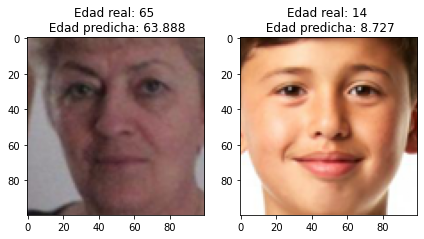

In [40]:
real_age_1 = str(Y_val[sample_pred_1])
prediction_image_1 = np.expand_dims(X_val[sample_pred_1], axis=0)
predicted_age_1 = float(cnn_adam_model.predict(prediction_image_1)[0])

real_age_2 = str(Y_val[sample_pred_2])
prediction_image_2 = np.expand_dims(X_val[sample_pred_2], axis=0)
predicted_age_2 = float(cnn_adam_model.predict(prediction_image_2)[0])

plt.figure(figsize=(7, 7))
plt.subplot(1, 2, 1)
plt.imshow(X_val[sample_pred_1])
plt.title("Edad real: {} \n Edad predicha: {:.3f}".format(real_age_1, predicted_age_1))
plt.subplot(1, 2, 2)
plt.imshow(X_val[sample_pred_2])
plt.title("Edad real: {} \n Edad predicha: {:.3f}".format(real_age_2, predicted_age_2))

#### Comparación modelos

En la siguiente imagen se presentan de manera gráfica los resultados de los modelos anteriores para poder compararlos, tanto en entrenamiento como en validación. 

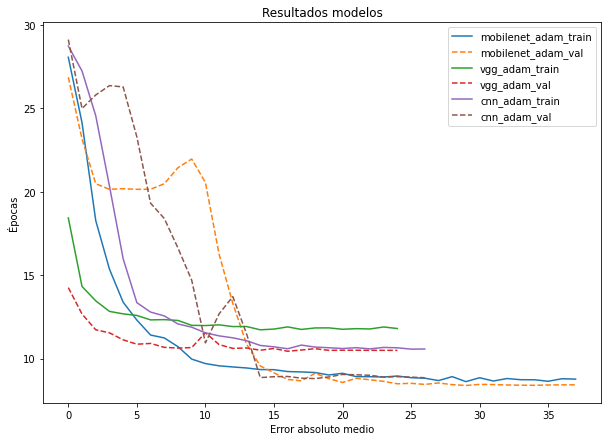

In [41]:
# color_bar = ["b", "b", "g", "g", "r", "r"]

plt.figure(figsize=(10, 7))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-mae'])),results[cond]['train-mae'], '-', label=cond+"_train")
    plt.plot(range(len(results[cond]['val-mae'])),results[cond]['val-mae'], '--', label=cond+"_val")
plt.title("Resultados modelos")
plt.xlabel("Error absoluto medio")
plt.ylabel("Épocas")
plt.legend()
plt.show()

### Test

Por último, se quieren testear los modelos con el conjunto del dataset destinado para ello. Por lo tanto se calculan los errores absolutos, el resultado que se obtiene para cada uno indica el número de años por los que se equivoca el modelo como media. 

In [42]:
test_mobilenet_model = mobilenet_model.evaluate(X_test, Y_test, batch_size=128)
test_vgg_model = vgg_adam.evaluate(X_test, Y_test, batch_size=128)
test_cnn_model = cnn_adam_model.evaluate(X_test, Y_test, batch_size=128)

print("El error absoluto en años para el modelo mobilnet es {:.3f}".format(test_mobilenet_model[1]))
print("El error absoluto en años para el modelo vgg es {:.3f}".format(test_vgg_model[1]))
print("El error absoluto en años para el modelo cnn es {:.3f}".format(test_cnn_model[1]))

12/12 [==============================] - 0s 27ms/step - loss: 9.1635 - mean_absolute_error: 9.1635
El error absoluto en años para el modelo mobilnet es 8.587
El error absoluto en años para el modelo vgg es 10.815
El error absoluto en años para el modelo cnn es 9.164


Basándose en los resultados previos y en los errores absolutos de los modelos, se ha decidido escoger CNN como el mejor modelo ya que presenta un error bajo en un tiempo de ejecución asumible. A continuación, se testean diferentes imágenes con este modelo. 

Text(0.5, 1.0, 'Edad real: 33 \n Edad predicha: 50.334')

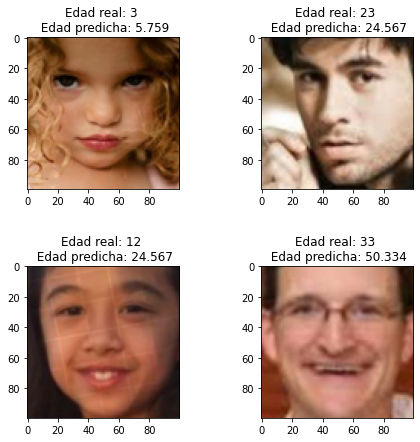

In [45]:
sample_test_1 = random.randint(0, len(X_test))
sample_test_2 = random.randint(0, len(X_test))
sample_test_3 = random.randint(0, len(X_test))
sample_test_4 = random.randint(0, len(X_test))


real_age_1 = str(Y_test[sample_test_1])
prediction_image_1 = np.expand_dims(X_test[sample_test_1], axis=0)
predicted_age_1 = float(cnn_adam_model.predict(prediction_image_1)[0])

real_age_2 = str(Y_test[sample_test_2])
prediction_image_2 = np.expand_dims(X_test[sample_test_2], axis=0)
predicted_age_2 = float(cnn_adam_model.predict(prediction_image_2)[0])

real_age_3 = str(Y_test[sample_test_3])
prediction_image_3 = np.expand_dims(X_test[sample_test_3], axis=0)
predicted_age_3 = float(cnn_adam_model.predict(prediction_image_2)[0])

real_age_4 = str(Y_test[sample_test_4])
prediction_image_4 = np.expand_dims(X_test[sample_test_4], axis=0)
predicted_age_4 = float(cnn_adam_model.predict(prediction_image_4)[0])

plt.figure(figsize=(7, 7))
plt.subplots_adjust(wspace=0.5, hspace=0.5)

plt.subplot(2, 2, 1)
plt.imshow(X_test[sample_test_1])
plt.title("Edad real: {} \n Edad predicha: {:.3f}".format(real_age_1, predicted_age_1))
plt.subplot(2, 2, 2)
plt.imshow(X_test[sample_test_2])
plt.title("Edad real: {} \n Edad predicha: {:.3f}".format(real_age_2, predicted_age_2))
plt.subplot(2, 2, 3)
plt.imshow(X_test[sample_test_3])
plt.title("Edad real: {} \n Edad predicha: {:.3f}".format(real_age_3, predicted_age_3))
plt.subplot(2, 2, 4)
plt.imshow(X_test[sample_test_4])
plt.title("Edad real: {} \n Edad predicha: {:.3f}".format(real_age_4, predicted_age_4))

### Conclusiones

A continuación se presentan las conclusiones obtenidas en el trabajo:

*   En primer lugar, sobre el dataset es importante decir que como se ha mostrado había un claro desbalanceo de las edades lo cual ha podido afectar a la hora de entrenar los modelos. Además, no se trataba de un dataset muy grande lo cual probablement también haya afectado aunque se haya realizado data augmentation. 
*   En cuanto a los resultados y el modelo elegido, se ha dudado entre MobileNET y CNN ya que los dos presentaban resultados similares, y aunque el primero ha mostrado resultados más consistentes en las distintas pruebas realizadas, el segundo ha conseguido llegar a resultados muy similares en menos tiempo, lo que supone una ventaja. 
*   Además, hay que tener en cuenta que dada la complejidad del problema abordado, aunque el fallo haya sido de media de alrededor de 10 años, lo cual puede parecer un error significativo, en ocasiones ni siquiera el ojo humano es capaz de diferenciar claramente la edad de personas adultas. A esto se debe sumar el hecho de que no todas las personas aparentan la misma edad aún teniendola, por lo que esto puede confundir al algoritmo. 


*   Si se quisiera utilizar este trabajo como base para una aplicación real de detección de edad se debería partir de un dataset mayor y más balanceado y trabajar en reducir el error ya que una media de alrededor 10 años de equivocación puede suponer un gran fallo. 



